In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
#remove the average signal
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    df_adjusted=df_camera-df_fitting
    return df_adjusted

In [4]:
#function that takes the camera data and removes the temperautre effect
#1 calculate the total number of counts per shot
#2 fit a 2 order polynomial to this
#3 remove the trend from original data
def rmv_tmp_effect(df_camera):
    #1 calculate the average number of counts per shot
    cam_avg=df_camera.sum(axis=1)/len(df_camera.columns)
    
    #2 fit a 2 order polynomial to this
    x=np.linspace(0,len(cam_avg)-1,len(cam_avg))
    p1,p2,b = np.polyfit(x, cam_avg, 2)
    #print(p1,p2,b)

    adj=p1*x**2+p2*x #each shot needs to be adjusted by this value (x is shot index)
    #print(df_camera.sub(adj,axis=0))
    return df_camera.sub(adj,axis=0)

In [5]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

In [6]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

#input a single shot and returns the position of the cut-off
#This will be SLOWER because we need to recalculate the max
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

In [7]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

In [8]:
#Average shots with same input param
#NOTE: the return 'integ' values are the normalized
def metric_shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr norm'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

## Read camera data

In [9]:
filename_camera='datasets/galadriel_dataset_24_09_18_phys.h5'

In [10]:
df_input_camera=pd.read_hdf(filename_camera,'df_input')
df_camera=pd.read_hdf(filename_camera,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input_camera)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4  Laser Energy
0          172691  35300.0 -17000.0 -4750000.0      0.001748
1          172692  35300.0 -17000.0 -4750000.0      0.001762
2          172693  35300.0 -17000.0 -4750000.0      0.001785
3          172694  35300.0 -17000.0 -4750000.0      0.001697
4          172695  34800.0 -13000.0 -5050000.0      0.004275
...           ...      ...      ...        ...           ...
3569       176260  34800.0  11000.0 -5350000.0      0.004952
3570       176261  34800.0  11000.0 -5350000.0      0.005166
3571       176262  34800.0  11000.0 -5350000.0      0.004867
3572       176263  34800.0  11000.0 -5350000.0      0.005132
3573       176264  34800.0  11000.0 -5350000.0      0.005383

[3574 rows x 5 columns]
----
Camera 1D
         0        1        2        3        4        5        6        7     \
0      6.1000   6.1075   6.7050   5.7650   6.4175   5.4300   6.8350   5.7300   
1     11.3200  11.6300  12.1400  11.7350  11.9700  11.5975 

In [11]:
#remove the temp effect
df_camera_no_tmp=rmv_tmp_effect(df_camera)

#smooth the whole camera dataframe
df_camera_smooth=df_camera_no_tmp.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')
#remove the last values
df_camera_smooth=df_camera_smooth.iloc[:,0:2000].copy()

#then remove the mean signal
lastpoints=300
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

### construct the dataframe with the camera metrics

In [12]:
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)
#normalize by the laser energy
df_metrics['Integr norm']=df_metrics['Integr'].div(df_input_camera['Laser Energy'])

/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

Error in the find max


/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_56265/3460704502.py:3: Optimize

In [13]:
#drop shots with wrong peak E calculations
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.5]

good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
df_input_reduced=df_input_camera.iloc[good_shots_list]

#reset the index
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

In [14]:
#Average the shots with same input coeeficients
df_metrics_avg=metric_shot_average(df_input_reduced,df_metrics_reduced)

In [15]:
df_metrics_avg

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,35300.0,-17000.0,-4750000.0,1.171111,0.130331,5.442997,0.233745,39201.111812,15782.737233
1,34800.0,-13000.0,-5050000.0,1.306748,0.164159,5.457378,0.111727,13533.917651,4876.878349
2,34400.0,-5000.0,-5350000.0,0.772202,0.000000,4.864612,0.000000,1142.292246,0.000000
3,34800.0,-17000.0,-4450000.0,1.494858,0.235228,5.300854,0.397416,26106.011330,18690.841743
4,34600.0,15000.0,-5350000.0,0.651573,0.079900,3.621259,1.392441,2750.246573,2354.227102
...,...,...,...,...,...,...,...,...,...
682,34500.0,15000.0,-4450000.0,1.241422,0.280237,3.868997,0.288744,4302.329069,2547.746194
683,34400.0,-13000.0,-4450000.0,1.312405,0.512862,2.338690,1.541328,2541.932092,3013.742610
684,34700.0,-9000.0,-4450000.0,1.431090,0.007193,4.056676,0.269376,8969.177105,4175.831917
685,35200.0,-13000.0,-4750000.0,1.291376,0.131705,4.516234,0.632082,34947.333198,18900.922883


## Take the good performers

In [16]:
df_good_perf=df_metrics_avg[df_metrics_avg['Integr mean']>25000]

In [17]:
df_good_perf

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
0,35300.0,-17000.0,-4750000.0,1.171111,0.130331,5.442997,0.233745,39201.111812,15782.737233
3,34800.0,-17000.0,-4450000.0,1.494858,0.235228,5.300854,0.397416,26106.011330,18690.841743
12,34800.0,-9000.0,-4450000.0,1.465374,0.056012,5.539676,0.106955,25551.337861,11258.840731
17,35100.0,-17000.0,-4750000.0,1.293293,0.195839,5.308451,0.228441,31034.964976,20980.571581
28,35400.0,-5000.0,-4750000.0,1.407306,0.123702,5.612678,0.134399,39850.921616,12692.277401
...,...,...,...,...,...,...,...,...,...
653,35000.0,-21000.0,-4750000.0,1.428372,0.163522,4.461646,0.665690,25401.357245,14744.833280
675,35400.0,-9000.0,-5050000.0,1.469628,0.127565,4.807357,0.097112,30931.969971,5834.935667
676,34700.0,-9000.0,-4150000.0,1.377840,0.076288,4.679552,0.348414,27943.918810,10518.920738
679,35000.0,-17000.0,-4450000.0,1.291075,0.097966,4.744531,0.666757,44024.888832,18444.509097


# Train the forward model

In [18]:
filename='datasets/galadriel_dataset_24_09_18.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [19]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

#train forward model with Random forest
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

In [20]:
#test_input=df_good_perf[['order2','order3','order4']].iloc[2].tolist()
good_perf_input=df_good_perf[['order2','order3','order4']]
print(good_perf_input)

      order2   order3     order4
0    35300.0 -17000.0 -4750000.0
3    34800.0 -17000.0 -4450000.0
12   34800.0  -9000.0 -4450000.0
17   35100.0 -17000.0 -4750000.0
28   35400.0  -5000.0 -4750000.0
..       ...      ...        ...
653  35000.0 -21000.0 -4750000.0
675  35400.0  -9000.0 -5050000.0
676  34700.0  -9000.0 -4150000.0
679  35000.0 -17000.0 -4450000.0
685  35200.0 -13000.0 -4750000.0

[85 rows x 3 columns]


In [21]:
y_predict=rf.make_rf_prediction(forward_model_rf,good_perf_input)

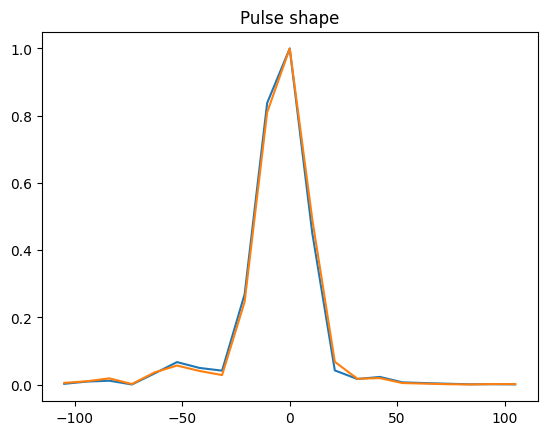

In [22]:
#plt.plot(df_time_val,y_predict[7])
plt.plot(df_time_val,y_predict[8])
#plt.plot(df_time_val,y_predict[9])
#plt.plot(df_time_val,y_predict[10])
#plt.plot(df_time_val,y_predict[11])
plt.plot(df_time_val,y_predict[0])
plt.title('Pulse shape')
plt.show()

Text(0.2, 0.3, '$\\beta^4=$-4750000.0')

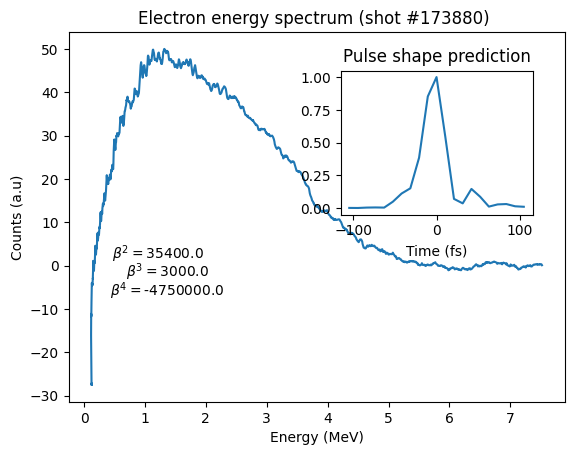

In [23]:
#plot the E distribution and its puls prediction
good_shot_index=35
input_param=good_perf_input.iloc[good_shot_index]
#look for the shots with the same Dazller parameters
df_input_shot=df_input_camera[df_input_camera['order2']==input_param['order2']]
df_input_shot=df_input_shot[df_input_shot['order3']==input_param['order3']]
df_input_shot=df_input_shot[df_input_shot['order4']==input_param['order4']]

shot_index=df_input_shot.index.values[0] #get the first shot with those param
shot_num=df_input_shot['shot number'].iloc[0]
order2=input_param['order2']
order3=input_param['order3']
order4=input_param['order4']

e_dist_adj=df_camera_adjusted.loc[shot_index]
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

fig, ax = plt.subplots()

left, bottom, width, height = [0.55, 0.5, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(df_time_val,y_predict[good_shot_index])
ax2.set_xlabel('Time (fs)')
ax2.set_title('Pulse shape prediction')

ax.plot(x_ene,e_dist_adj)
#plt.xlim(0,8)
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Counts (a.u)')
ax.set_title('Electron energy spectrum (shot #'+str(shot_num)+') ')

ax.text(0.18, 0.4, r'$\beta^2=$'+str(order2), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.2, 0.35, r'$\beta^3=$'+str(order3), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.2, 0.3, r'$\beta^4=$'+str(order4), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# PCA

### Train the PCA

In [24]:
pca_comp=5
#normalize the pulse dataset
scaler=StandardScaler()
df_time_norm = scaler.fit_transform(y_train) #only on the training set
#Train the pca space using the _morm
pca=PCA(n_components=pca_comp).fit(df_time_norm)
#convert to pca space
df_time_pca=pca.transform(df_time_norm)

### Transform prediction to PCA space

In [25]:
#normalize
y_predict_norm=scaler.fit_transform(y_predict)
#transfrom to PCA spcae
y_predict_pca=pca.transform(y_predict_norm)

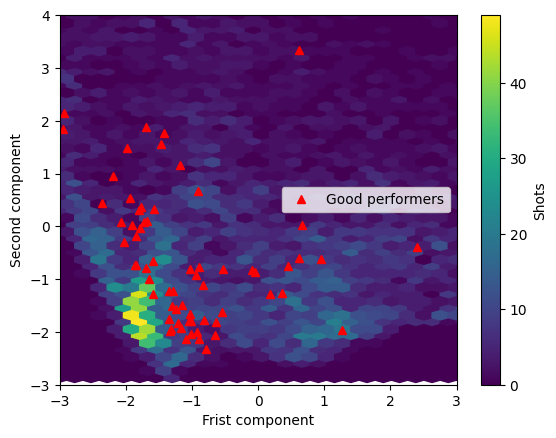

In [26]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,0], df_time_pca[:,1],gridsize=100)#,cmap='jet')
plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('Frist component')
ax.set_ylabel('Second component')
ax.set_xlim(-3,3)
ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [27]:
#plt.plot(df_time_pca[:,0],df_time_pca[:,1],marker='d',linestyle='None',label='All shots')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='s',linestyle='None',label='Good performers')
#plt.xlabel('First component')
#plt.ylabel('Second component')
#plt.legend()

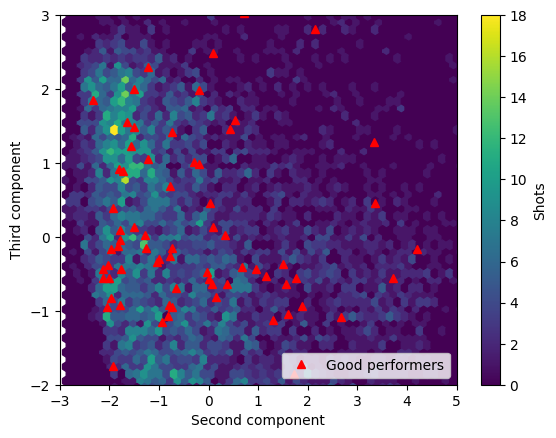

In [28]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,1], df_time_pca[:,2],gridsize=100)#,cmap='jet')
plt.plot(y_predict_pca[:,1],y_predict_pca[:,2],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('Second component')
ax.set_ylabel('Third component')
ax.set_xlim(-3,5)
ax.set_ylim(-2,3)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [29]:
#plt.plot(df_time_pca[:,1],df_time_pca[:,2],marker='d',linestyle='None',label='All shots')
#plt.plot(y_predict_pca[:,1],y_predict_pca[:,2],marker='s',linestyle='None',label='Good performers')
#plt.xlabel('Second component')
#plt.ylabel('Third component')
#plt.legend()

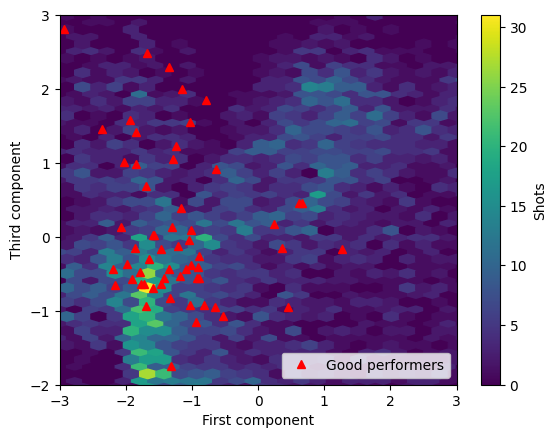

In [30]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,0], df_time_pca[:,2],gridsize=100)#,cmap='jet')
plt.plot(y_predict_pca[:,0],y_predict_pca[:,2],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('First component')
ax.set_ylabel('Third component')
ax.set_xlim(-3,3)
ax.set_ylim(-2,3)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [31]:
#plt.plot(df_time_pca[:,0],df_time_pca[:,2],marker='d',linestyle='None')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,2],marker='s',linestyle='None')
#plt.xlabel('First component')
#plt.ylabel('Third component')

/tmp/ipykernel_56265/2304641190.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y_predict_pca[:,0],y_predict_pca[:,1], y_predict_pca[:,2],c='r',cmap='jet')


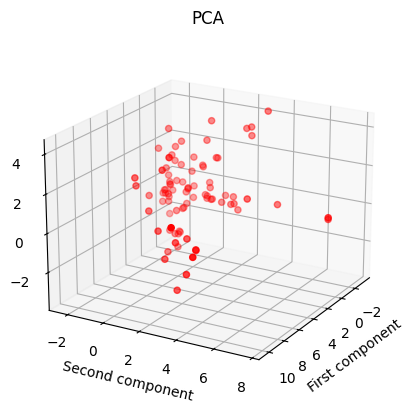

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(df_time_pca[:,0],df_time_pca[:,1], df_time_pca[:,2],c='c',cmap='jet')
ax.scatter(y_predict_pca[:,0],y_predict_pca[:,1], y_predict_pca[:,2],c='r',cmap='jet')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=30)
plt.title('PCA')
plt.show()

## Analysis of ALL AVG shots/predictions

In [33]:
#df_metrics_avg[['order2','order3','order4']]
y_predict_all=rf.make_rf_prediction(forward_model_rf,df_metrics_avg[['order2','order3','order4']])
#convert the prediction to PCA space
#normalize
y_predict_all_norm=scaler.fit_transform(y_predict_all)
#transfrom to PCA spcae
y_predict_all_pca=pca.transform(y_predict_all_norm)

In [34]:
y_predict_all_pca

array([[-2.94881799, -1.09468885, -0.49944924, -0.11032393,  0.21252667],
       [ 0.68123717,  3.13823371, -0.03416895, -1.75605956, -1.5648231 ],
       [-2.27361512, -1.97401491, -2.01288166, -0.0225904 ,  0.60012731],
       ...,
       [-2.82216376,  1.38780884, -0.27321628, -0.6843077 , -0.83722404],
       [-2.86778591, -0.37352655, -0.95179336, -0.08293301,  0.06938741],
       [ 1.04698929, -1.36675913,  1.0987812 , -0.68601051,  0.18645166]])

In [35]:
# Create a dataframe with the PCA values from the rpediciton and the metrics
#Note:prediction has reset index

In [36]:
df_predict_pca=pd.DataFrame(y_predict_all_pca)
df_predict_pca.rename({0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'},
                      axis=1,inplace=True)

df_metric_and_pca=pd.concat([df_metrics_avg.reset_index(drop=True),df_predict_pca],axis=1)

In [37]:
df_metric_and_pca

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std,PC1,PC2,PC3,PC4,PC5
0,35300.0,-17000.0,-4750000.0,1.171111,0.130331,5.442997,0.233745,39201.111812,15782.737233,-2.948818,-1.094689,-0.499449,-0.110324,0.212527
1,34800.0,-13000.0,-5050000.0,1.306748,0.164159,5.457378,0.111727,13533.917651,4876.878349,0.681237,3.138234,-0.034169,-1.756060,-1.564823
2,34400.0,-5000.0,-5350000.0,0.772202,0.000000,4.864612,0.000000,1142.292246,0.000000,-2.273615,-1.974015,-2.012882,-0.022590,0.600127
3,34800.0,-17000.0,-4450000.0,1.494858,0.235228,5.300854,0.397416,26106.011330,18690.841743,-2.964809,-0.604293,0.381514,0.212369,-0.041151
4,34600.0,15000.0,-5350000.0,0.651573,0.079900,3.621259,1.392441,2750.246573,2354.227102,-1.765832,-1.515068,-0.755207,-1.105715,0.361067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,34500.0,15000.0,-4450000.0,1.241422,0.280237,3.868997,0.288744,4302.329069,2547.746194,3.757988,-1.335635,2.667892,-0.230720,-1.298256
683,34400.0,-13000.0,-4450000.0,1.312405,0.512862,2.338690,1.541328,2541.932092,3013.742610,-1.722343,2.193058,-2.038059,-0.805338,-2.153225
684,34700.0,-9000.0,-4450000.0,1.431090,0.007193,4.056676,0.269376,8969.177105,4175.831917,-2.822164,1.387809,-0.273216,-0.684308,-0.837224
685,35200.0,-13000.0,-4750000.0,1.291376,0.131705,4.516234,0.632082,34947.333198,18900.922883,-2.867786,-0.373527,-0.951793,-0.082933,0.069387


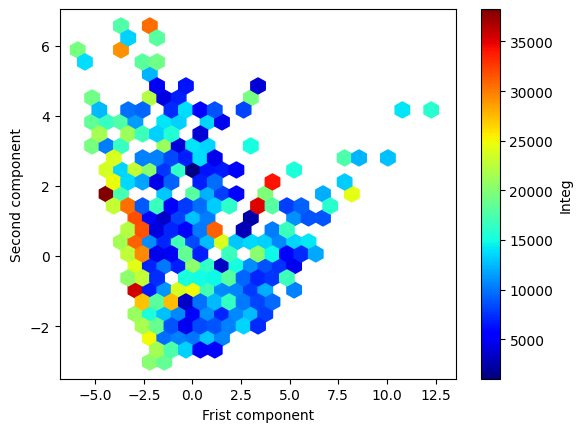

In [67]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_metric_and_pca['PC1'], df_metric_and_pca['PC2'], C=df_metric_and_pca['Integr mean'],
             gridsize=25,cmap='jet')
ax.set_xlabel('Frist component')
ax.set_ylabel('Second component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Integ')

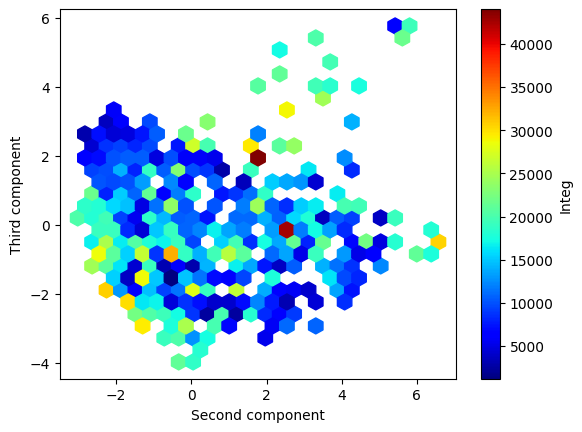

In [68]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_metric_and_pca['PC2'], df_metric_and_pca['PC3'], C=df_metric_and_pca['Integr mean'],
             gridsize=25,cmap='jet')
ax.set_xlabel('Second component')
ax.set_ylabel('Third component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Integ')

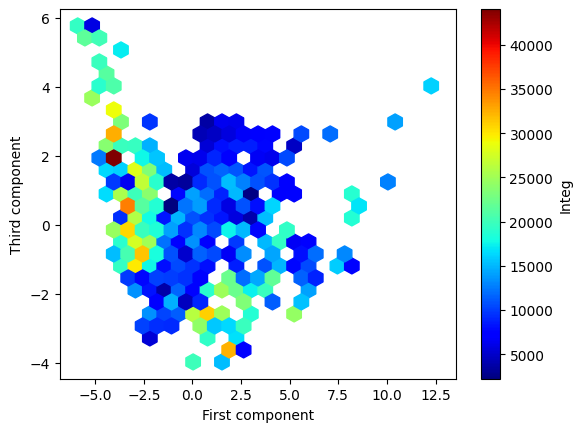

In [69]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_metric_and_pca['PC1'], df_metric_and_pca['PC3'], C=df_metric_and_pca['Integr mean'],
             gridsize=25,cmap='jet')
ax.set_xlabel('First component')
ax.set_ylabel('Third component')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Integ')

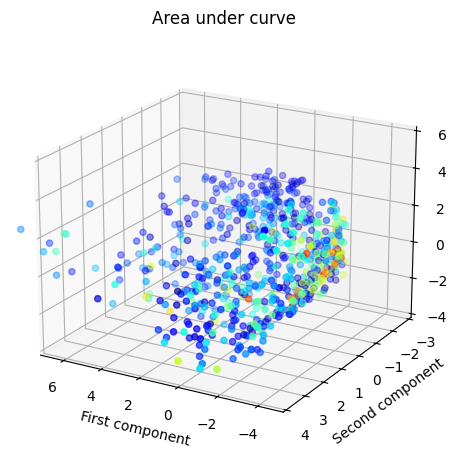

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(df_time_pca[:,0],df_time_pca[:,1], df_time_pca[:,2],c='c',cmap='jet')
ax.scatter(df_metric_and_pca['PC1'],df_metric_and_pca['PC2'], df_metric_and_pca['PC3'],c=df_metric_and_pca['Integr mean'],cmap='jet')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.set_xlim(-5,7)
ax.set_ylim(-3,4)
ax.set_zlim(-4,6)
ax.view_init(elev=20., azim=120)
plt.title('Area under curve')
fig.tight_layout()
plt.show()